1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5.1. Выполните когортный анализ пользователей.

5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 10-го урока python, раздел “Стильный урок”, степ 5.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [122]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as ss
from datetime import timedelta
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(
    font_scale = 1,
    style = 'whitegrid',
    rc = {'figure.figsize':(10,6)}
)

<h3>Анализ данных

<b>Таблица с уникальными идентификаторами пользователей</b>

In [123]:
# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/QXrVDUoQvFhIcg')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [124]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Пропущенных значений нет

<b>Товарные позиции, входящие в заказы</b>

In [125]:
# order_id — уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике<br>
# price —  цена за единицу товара
# freight_value —  вес товара

order_items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg', parse_dates=['shipping_limit_date'])
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [126]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Пропущенных значений нет

<b>Таблица заказов</b>

In [127]:
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0zWmh1bYP6REbw', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Уникальные статусы заказов в таблице orders (order_status):

created —  создан<br>
approved —  подтверждён<br>
invoiced —  выставлен счёт<br>
processing —  в процессе сборки заказа<br>
shipped —  отгружен со склада<br>
delivered —  доставлен пользователю<br>
unavailable —  недоступен<br>
canceled —  отменён

In [128]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [129]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

order_approved_at (время подтверждения оплаты заказа) - 160 пропущенных значений<br>
order_delivered_carrier_date (время передачи заказа в логистическую службу) - 1783 пропущенных значений<br>
order_delivered_customer_date (время доставки заказа) - 2965 пропущенных значений

<h3>Что должно считаться покупкой:<br></h3>
    Покупкой будет считаться заказы со статусом delivered, и заполненые полями order_approved_at, order_delivered_carrier_date, order_delivered_customer_date. 

In [130]:
orders_filtered = orders \
    .loc[orders.order_approved_at.notnull() 
    & orders.order_delivered_carrier_date.notnull()
    & orders.order_delivered_customer_date.notnull()]

print(orders_filtered.isnull().sum())

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64


In [131]:
orders_filtered = orders_filtered \
    .loc[orders_filtered.order_status == 'delivered']

<h3>1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [132]:
data = orders_filtered.merge(customers, how='inner', on='customer_id')

In [133]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [134]:
count_customers = data.groupby('customer_unique_id', as_index=0) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_count'}) \
    .sort_values('orders_count') \
    .query('orders_count == 1').shape[0]

count_customers

90536

Количество пользователей, которые совершили покупку только один раз: 90536

<h3>2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [135]:
# подготовка данных

undelivered_orders = orders.query('order_status in ["canceled", "unavailable"] & order_delivered_customer_date.isnull()')
undelivered_orders['month'] = undelivered_orders['order_purchase_timestamp'].dt.strftime('%m-%Y')
undelivered_orders['order_approved_at'] = undelivered_orders['order_approved_at'].isna()
undelivered_orders['order_delivered_carrier_date'] = undelivered_orders['order_delivered_carrier_date'].isna()
undelivered_orders['order_delivered_customer_date'] = undelivered_orders['order_delivered_customer_date'].isna()

In [136]:
# функция для определения статуса заказа

def check_status(x):
    if x['order_approved_at']== True:
        return 'Заказ не подтвержден'
    elif x['order_delivered_carrier_date']== True:
        return 'Заказ не передан в службу доставки'
    elif x['order_delivered_customer_date']== True:
        return 'Покупатель не получил заказ'

undelivered_orders['reasons_undelivered'] = undelivered_orders.apply(lambda x: check_status(x), axis=1)

In [137]:
# перевод на дату и сортировка колонки month

undelivered_orders['month'] = pd.to_datetime(undelivered_orders['month'], format='%m-%Y')
undelivered_orders = undelivered_orders.sort_values('month')

In [138]:
# Расчет количество не доставленных заказов 

undelivered_orders = undelivered_orders \
    .groupby(['month', 'reasons_undelivered'], as_index=0) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'count_'})

undelivered_orders

,month,reasons_undelivered,count_
0,2016-09-01,Заказ не передан в службу доставки,2
1,2016-10-01,Заказ не передан в службу доставки,20
2,2016-10-01,Заказ не подтвержден,6
3,2017-01-01,Заказ не передан в службу доставки,12
4,2017-01-01,Заказ не подтвержден,1
5,2017-02-01,Заказ не передан в службу доставки,60
6,2017-02-01,Заказ не подтвержден,2
7,2017-03-01,Заказ не передан в службу доставки,63
8,2017-03-01,Заказ не подтвержден,2
9,2017-04-01,Заказ не передан в службу доставки,23


In [139]:
# Расчет среднее не доставленных заказов по месяцам
undelivered_orders_mean = undelivered_orders.groupby('month', as_index=0).agg({'count_': 'mean'})
undelivered_orders_mean = undelivered_orders_mean.rename(columns={'count_': 'mean_'})
undelivered_orders_mean = undelivered_orders_mean.round(2)

In [140]:
undelivered_orders_percent = undelivered_orders \
    .groupby('reasons_undelivered', as_index=0) \
    .agg({'count_': 'sum'})

undelivered_orders_percent['percent'] = round((undelivered_orders_percent['count_'] / undelivered_orders_percent.count_.sum()) * 100, 2)
undelivered_orders_percent

,reasons_undelivered,count_,percent
0,Заказ не передан в службу доставки,1018,82.90
1,Заказ не подтвержден,141,11.48
2,Покупатель не получил заказ,69,5.62


Как видно из таблицы, цыпочка доставки заказа останавливается на "Заказ не передан в службу доставки". 

 <h3>3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [141]:
# join между orders и customer
data = orders_filtered.merge(customers, how='inner', on='customer_id')

In [142]:
# full join между orders, customer, order_items
full_data = data.merge(order_items, how='left', on='order_id')

In [143]:
# извлекаем данные о дне недели покупок
full_data['day_week'] = full_data['order_purchase_timestamp'].dt.day_name()

In [144]:
# Подсчет кол-во покупок
quantity_products = full_data \
    .groupby(['product_id', 'day_week'], as_index=0) \
    .agg({'price': 'count'}) \
    .sort_values('price', ascending=False) \
    .rename(columns=({'price': 'quantity'}))

In [145]:
# Определям в какой день недели товар чаще покупается
most_quantity_products = quantity_products.groupby('product_id', as_index=0).max() \
    .sort_values('quantity', ascending=False)

In [146]:
# Таблица товаров
most_quantity_products

,product_id,day_week,quantity
8427,422879e10f46682990de24d770e7f83d,Wednesday,93
19286,99a4788cb24856965c36a24e339b6058,Wednesday,91
21612,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,89
10612,53b36df67ebb7c41585e8d54d6772e08,Wednesday,76
6924,368c6c730842d78016ad823897a372db,Wednesday,67
...,...,...,...
12466,62a5a3de0af802fb3718a83c74c3ff8d,Sunday,1
12465,62a183c5f3895060ba1a8f1415694908,Friday,1
12464,62a068fa5b6d1cb8015c754504a10bfa,Thursday,1
12461,629beb8e7317703dcc5f35b5463fd20e,Wednesday,1


In [147]:
# сортировка дни недели

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
quantity_products['day_week'] = pd.Categorical(quantity_products['day_week'], categories=day_order, ordered=True)

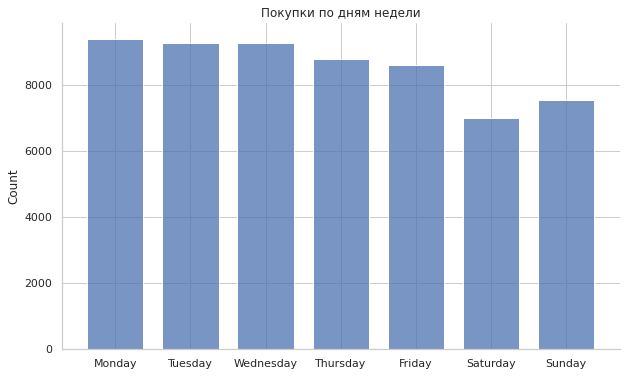

In [148]:
# Покупки по дням недели
plt.figure(figsize=(10, 6))
sns.histplot(quantity_products.day_week, shrink=0.75).set(xlabel=None)
plt.title('Покупки по дням недели')
sns.despine()

Вывод: На выходних набдлюдается спад, чем будни дни.

<h3>4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

In [149]:
# full join между data(customer, orders_filtered) и order_items
full_data = data.merge(order_items, how='left', on='order_id')

In [150]:
full_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [151]:
# извлекаем год, месяц, недель в месяце
full_data['year'] = full_data['order_purchase_timestamp'].dt.year
full_data['month'] = full_data['order_purchase_timestamp'].dt.month
full_data['week_in_month'] = round(full_data['order_purchase_timestamp'].dt.days_in_month/7, 2)

In [152]:
# подготовка для расчета среднего кол-во покупок в неделю

quantity_per_week = full_data.groupby(['customer_unique_id', 'year', 'month', 'week_in_month'], as_index=0) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'quantity'}) \
    .sort_values(['customer_unique_id', 'year', 'month'])

In [153]:
quantity_per_week['mean_quantity_per_week'] = round(quantity_per_week['quantity'] / quantity_per_week['week_in_month'], 2)

In [154]:
quantity_per_week.head()

,customer_unique_id,year,month,week_in_month,quantity,mean_quantity_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.43,1,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,4.43,1,0.23
2,0000f46a3911fa3c0805444483337064,2017,3,4.43,1,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,4.43,1,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017,11,4.29,1,0.23


<h3>5.Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. 

Вводные данные: 

Формирования когорты: первая покупка.<br>
Период когорты: 2017 год. <br>
Метрика: Retention

In [155]:
# используем full data, оставляем 2017 год и оставляем нужные колонки

df_2017 = full_data \
    .query('order_purchase_timestamp >= "2017-01-01" & order_purchase_timestamp <= "2017-12-31"') \
    .drop_duplicates(subset = 'order_id') \
    [['customer_unique_id', 'order_purchase_timestamp']]

In [156]:
# создаем нужные колонки order_month, cohort_month
df_2017['order_month'] = df_2017.order_purchase_timestamp.dt.to_period('M')
df_2017['cohort_month'] = df_2017.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

In [157]:
# Добавляем столбец с количеством месяцев с момента первой покупки
df_2017['cohort_index'] = (df_2017.order_month.dt.to_timestamp() - df_2017.cohort_month.dt.to_timestamp()).dt.days // 30


In [158]:
df_2017.head()

,customer_unique_id,order_purchase_timestamp,order_month,cohort_month,cohort_index
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09,1
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11,0
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07,2017-07,0
6,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05,2017-05,0
7,39382392765b6dc74812866ee5ee92a7,2017-01-23 18:29:09,2017-01,2017-01,0


In [159]:
# группипуем по cohort_month, cohort_index

cohort_data = df_2017.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()

In [160]:
cohort_data.head()

,cohort_month,cohort_index,customer_unique_id
0,2017-01,0,716
1,2017-01,1,4
2,2017-01,3,1
3,2017-01,4,3
4,2017-01,5,1


In [161]:
# создаем pivot таблицу

cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')

In [162]:
cohort_pivot.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-01,716.0,4.0,NaN,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1616.0,5.0,2.0,NaN,7.0,2.0,4.0,3.0,1.0,3.0,2.0,NaN
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,NaN,NaN
2017-04,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3450.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,NaN,NaN,NaN,NaN


In [163]:
# Рассчитываем коэффициент удержания (retention)
retention = cohort_pivot.div(cohort_pivot[0], axis=0)

# Выявляем когорту с самым высоким retention на 3-й месяц (индекс 2)
highest_retention = retention[2].idxmax()
highest_retention_value = retention[2].max()

print("Когорта с самым высоким retention на 3-й месяц:", highest_retention)
print("Коэффициент удержания:", round(highest_retention_value*100, 2))

Когорта с самым высоким retention на 3-й месяц: 2017-09
Коэффициент удержания: 0.55


In [164]:
retention

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-01,1.0,0.005587,NaN,0.001397,0.004190,0.001397,0.004190,0.001397,0.001397,NaN,0.004190,0.001397
2017-02,1.0,0.003094,0.001238,NaN,0.004332,0.001238,0.002475,0.001856,0.000619,0.001856,0.001238,NaN
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,NaN,NaN
2017-04,1.0,0.006203,0.002215,0.001772,0.002658,0.002658,0.003545,0.003101,0.003101,NaN,NaN,NaN
2017-05,1.0,0.004638,0.004638,0.002899,0.002899,0.003188,0.004058,0.001449,NaN,NaN,NaN,NaN
2017-06,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005329,0.003464,0.002398,0.002931,0.002132,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006902,0.003451,0.002711,0.003451,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006993,0.005495,0.002498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
retention_style = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Greens')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
retention_style

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-01,100.00%,0.56%,,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,,0.42%,0.14%
2017-02,100.00%,0.31%,0.12%,,0.43%,0.12%,0.25%,0.19%,0.06%,0.19%,0.12%,
2017-03,100.00%,0.44%,0.36%,0.40%,0.36%,0.16%,0.16%,0.32%,0.32%,0.08%,,
2017-04,100.00%,0.62%,0.22%,0.18%,0.27%,0.27%,0.35%,0.31%,0.31%,,,
2017-05,100.00%,0.46%,0.46%,0.29%,0.29%,0.32%,0.41%,0.14%,,,,
2017-06,100.00%,0.49%,0.40%,0.43%,0.30%,0.40%,0.36%,,,,,
2017-07,100.00%,0.53%,0.35%,0.24%,0.29%,0.21%,,,,,,
2017-08,100.00%,0.69%,0.35%,0.27%,0.35%,,,,,,,
2017-09,100.00%,0.70%,0.55%,0.25%,,,,,,,,


<h3>6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Используем full data для расчетов, создаем датасет df_rfm, оставляем нужные колонки

In [166]:
# full_data из data(customer, orders_filtered) и order_items

df_rfm = full_data[['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'price']]

In [167]:
df_rfm.head()

,order_id,customer_unique_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,19.90


In [168]:
orders_rfm = df_rfm \
    .groupby(['order_id', 'customer_unique_id', 'order_purchase_timestamp'], as_index=0) \
    .agg({'price': 'sum'})

In [169]:
orders_rfm.head()

,order_id,customer_unique_id,order_purchase_timestamp,price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90


In [170]:
period = (orders_rfm.order_purchase_timestamp.max() - orders_rfm.order_purchase_timestamp.min()).days
period 

713

Задаем NOW на один день после последней покупки. Эта дата будет использоваться в качестве ориентира для расчета показателя Recency.

Дата первой и последней покупки

In [171]:
print(f'''Дата первой покупки: {orders_rfm.order_purchase_timestamp.min()}, 
Дата последней покупки:{orders_rfm.order_purchase_timestamp.max()}, 
Период наблюдений: {(orders_rfm.order_purchase_timestamp.max() - orders_rfm.order_purchase_timestamp.min()).days} дней''')

Дата первой покупки: 2016-09-15 12:16:38, 
Дата последней покупки:2018-08-29 15:00:37, 
Период наблюдений: 713 дней


In [172]:
NOW = (orders_rfm['order_purchase_timestamp'].max() + timedelta(days=1))
NOW

Timestamp('2018-08-30 15:00:37')

Суммируем price по order_id 

In [173]:
orders_rfm = orders_rfm \
    .groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'], as_index=0)\
    .agg({'price': 'sum'})

Добавляем колонку с количеством дней между покупкой и NOW.


In [174]:
orders_rfm['days_since_order'] = (NOW - orders_rfm['order_purchase_timestamp']).dt.days

Расчет Recency, Frequency, Monetary

In [175]:
rfm = orders_rfm.groupby('customer_unique_id', as_index=0)\
    .agg({'order_id': 'nunique',
          'price': 'sum',
          'days_since_order': 'min'}) \
    .rename(columns={'days_since_order': 'Recency', 
                     'order_id': 'Frequency', 
                     'price': 'Monetary'})

rfm.head()

,customer_unique_id,Frequency,Monetary,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,115
2,0000f46a3911fa3c0805444483337064,1,69.00,537
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,288


Разбиваем RFM на сегменты

In [176]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Frequency для всех квантили показывает 1 покупку. Посмотрим колонку Frequency

In [177]:
rfm.Frequency.value_counts(normalize=True).mul(100)

1     97.000086
2      2.755636
3      0.193923
4      0.029999
5      0.009643
6      0.005357
7      0.003214
15     0.001071
9      0.001071
Name: Frequency, dtype: float64

Frequency разбиваем по простому одна покупка = один балл

Функции для присвоения рангов от 1 до 5. Меньшее значение Recency лучше, в то время как более высокие значения Frequency и Monetary лучше.

In [178]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5    
    
def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 4:
        return 4
    else:
        return 5   

Получаем оценки R, F и M для каждого клиента.

In [179]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

rfm.head()

,customer_unique_id,Frequency,Monetary,Recency,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,112,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,115,4,1,1,411
2,0000f46a3911fa3c0805444483337064,1,69.00,537,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,321,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,288,2,1,5,215


### Сегменты на основе оценок R и F
Champions R=5, F = \[4-5\]	Купили недавно, покупают часто и тратят больше всего<br><br>Loyal Customers	(R=\[3-4\], F=\[4-5\]) Совершайте покупки на регулярной основе.<br><br>Potential Loyalist (R=\[4-5\], F=\[2-3\]) Недавние клиенты со средней частотой.<br><br>New Customers (R=5, F=1)	Покупал совсем недавно, но не часто<br><br>Promising (R=4, F=1)	Недавно покупал, но не часто.<br><br>Customers Needing Attention (R=3, F=3)	Недавность, частота и денежные показатели выше среднего. <br><br>About To Sleep (R=3, F=\[1-2\]')	Недавность и частота ниже среднего. Клиенты будут потеряны, если их не активизировать.<br><br>At Risk	(R=\[1-2\], F=\[3-4\]) Клиент часто совершал покупки, но очень давно. Нужно вернуть их обратно!<br><br>Can’t Lose (R=\[1-2\], F=5) Клиент раньше часто совершал покупки, но долгое время не возвращался.<br><br>Hibernating	(R=\[1-2\], F=\[1-2\])  Последняя покупка была совершена давно и количество заказов было низким. Клиен может быть потерян.

In [180]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Frequency,Monetary,Recency,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,112,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,115,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,1,69.00,537,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,321,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,288,2,1,5,215,hibernating


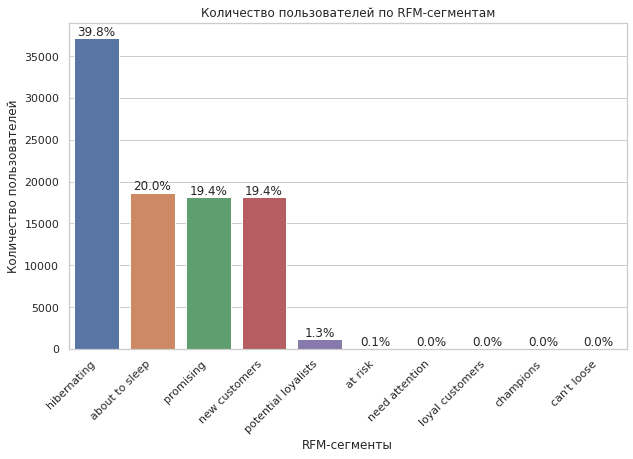

In [181]:
# сортировка columns
segment_counts = rfm.Segment.value_counts().index

ax = sns.countplot(data = rfm, x='Segment', order=segment_counts)
ax.set(xlabel='RFM-сегменты', ylabel ='Количество пользователей', title = 'Количество пользователей по RFM-сегментам')
plt.xticks(rotation=45, ha='right');

# Получение общего количества значений
total = rfm.shape[0]

# Добавление процентов на столбцы
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.show()

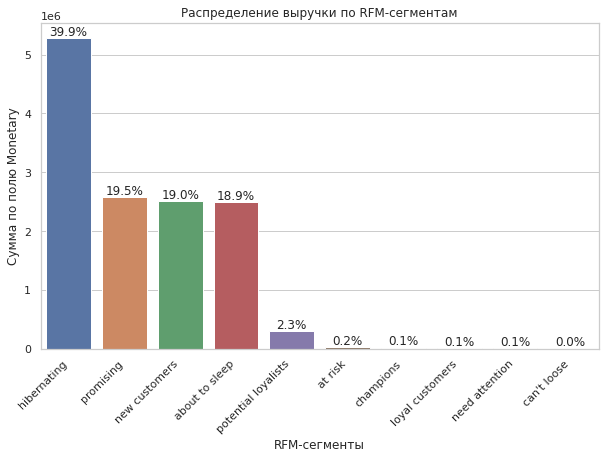

In [182]:
# Группировка и агрегация
sum_segment = rfm.groupby('Segment', as_index=False).agg({'Monetary': 'sum'}).sort_values('Monetary', ascending=False)

# Создание barplot
ax2 = sns.barplot(data=sum_segment, x='Segment', y='Monetary')
ax2.set(xlabel='RFM-сегменты', ylabel='Сумма по полю Monetary', title='Распределение выручки по RFM-сегментам')
plt.xticks(rotation=45, ha='right')

   
# Получение общего количества значений
total_monetary = sum_segment['Monetary'].sum()  

for p in ax2.patches:
    height = p.get_height()
    percentage = (height / total_monetary) * 100
    ax2.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.show()

### Выводы:

1. **40% клиентов** принадлежат к сегменту **Hibernating**. Эти покупатели давно сделали одну покупку и не вернулись. Однако именно они обеспечили 40% общей выручки за последние два года. Для их возвращения можно предложить специальные акции или персонализированные скидки, а также представить им другие актуальные товары и услуги. Также стоит выяснить причины, по которым клиенты не возвращаются после первой покупки. Возможные причины могут включать высокие цены, длительную доставку или неудобный веб-сайт.

2. **20% клиентов** относятся к сегменту **About to sleep**. Эти покупатели наиболее подвержены риску ухода, и этот сегмент важнее, чем Hibernating. Основная задача — активно делиться полезной информацией и предлагать популярные товары. Также стоит вводить скидки и промокоды, чтобы побудить их делать больше покупок. Этот сегмент приносит 19% дохода.

3. Следующие две ключевые группы — это **Promising** и **New customers**, которые составляют 39% клиентской базы и обеспечивают 38,5% дохода. Главная цель — удержание клиентов и формирование четкого понимания нашего бренда. В работе с этими сегментами необходимо акцентировать внимание на наших преимуществах по сравнению с конкурентами. Мы можем предложить скидки на первые или вторые крупные покупки и регулярно предоставлять выгодные промокоды.

4. У компании крайне низкий уровень лояльных клиентов, практически равный нулю. Перед разработкой стратегии продвижения важно провести анализ текущей ситуации: проверить актуальность цен по сравнению с рынком, удобство сайта и эффективность логистики.